#Machine Learning Estadístico para Interfaces Cerebro-Computadora

## Trabajo Práctico de Laboratorio de Computación I: Introducción al procesamiento de EEG y paradigmas de BCI

Este TPLC tiene como objetivo que el alumno sea capaz de:
1. Afianzar los conocimientos sobre BCI aprendidos en el encuentro teórico.
2. Implementar algoritmos básicos para el pre-procesamiento de las señales.
3. Comprender la caracterı́sticas de los diferentes marcadores neurofisiológicos utilizados en BCI.


Es **requisito** para aprobar este curso que esta guía práctica sea completada y enviada para su evaluación. Se aceptan trabajos realizados en forma grupal de *hasta dos alumnos por grupo*.


❗Antes de comenzar recordá hacer una copia de este documento de manera que puedas editarlo y guardar los cambios en tu Drive.

## Parte I: ¿Cuál es mi BCI?

En un laboratorio se está diseñando un experimento que involucre el uso de interfaces cerebro computadora (BCI) para el comando de un auto a baterı́a. Para ello, las investigadoras desean
utilizar un paradigma en el que el usuario de la BCI no deba ser entrenado, y que además, pueda ser comandado por la mayorı́a de los posibles usuarios. En este sentido deciden utilizar
como marcador neurofisiológico potenciales evocados visuales en estado estable (SSVEP, por sus
siglas en inglés) medido mediante señales de electroencefalogrı́a (EEG) de superficie. Asimismo,
diseñan un protocolo de estimulación como se muestra a continuación:

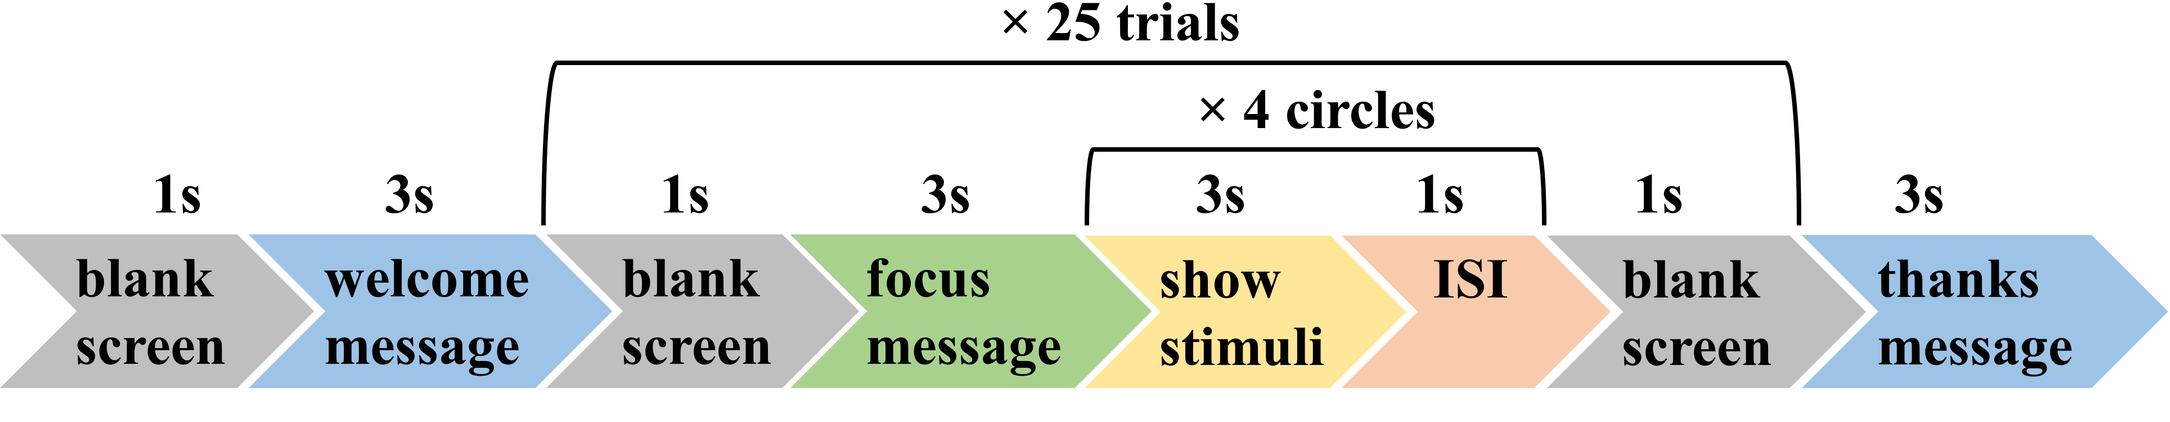

** Imagen modificada de [1]

❗ Si bien los investigadores ya tienen todo listo para comenzar los registros, se dan cuenta que
deben aún completar los datos del experimento en su carpeta de información, en dónde deben
clasificar su experimento según los posibles tipos de BCI.

❓ ¿Los ayudas indicando el tipo de BCI que diseñaron? --> (utilizá las definiciones dadas en clase)

🤓 Escribí tu rta. acá

## Parte II: pre-procesamientos básicos

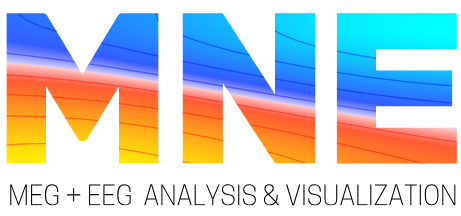

Durante este curso, vamos a utilizar la biblioteca [MNE-Python](https://mne.tools/stable/index.html), una biblioteca de código abierto que permite visualizar, analizar y explorar datos neurofisiológicos. Si no estás aún familiarizado con MNE-Python, te invito a chequear todos los tutoriales y ejemplos que ellos proveen (pero no ahora, esto no es un curso de MNE-Python 😜).

MNE-Python no está pre-instalada en el entornos virtual Python que tiene Colab. Como toda bibliotecas muy específica, debe instalarse cada vez que abrimos la Colab 👇


In [2]:
# ejecutá esta celda para instalar MNE
!pip install MNE


[notice] A new release of pip available: 22.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# !pip install pyqt5

# %matplotlib qt5

y voilá, ya tenemos instalado MNE para comenzar 😎

In [4]:
# Importamos las bibliotecas y funciones
import numpy as np
import matplotlib.pyplot as plt
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne import Epochs, pick_types, events_from_annotations
import mne

Para comenzar vamos a visualizar una señal de EEG por primera vez. Vamos a utilizar datos facilmente accesibles mediante MNE. En particular vamos a utilizar datos ERPs adquiridos con EEG de 60 canales de manera simulánea con MEG.

Esta base de datos, al igual que todas las que utilizaremos en el curso, pertenece al [repositorio](https://mne.tools/stable/overview/datasets_index.html) de base de datos de MNE publicamente accesibles.

In [5]:
# importamos los datos
root = mne.datasets.sample.data_path() / "MEG" / "sample"
raw_file = root / "sample_audvis_raw.fif"
raw = mne.io.read_raw_fif(raw_file, preload=False) # objeto rae the mne

Opening raw data file C:\Users\felip\mne_data\MNE-sample-data\MEG\sample\sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.


`raw` es un objeto instanciado de la clase [Raw](https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw) de MNE. Como tal tiene varios métodos de gran utilidad, que hiremos utilizando a lo largo del curso. Te invito a chusmearlos 😉

En este curso, nos vamos a centrar en trabajar con la señal de EEG. Para ello, vamos a utilizar la función `pick` (método del objeto `raw`) a modo de restringir el estudio a sólo un tipo de señal de interés: el EEG

In [6]:
raw.pick(["eeg"]).load_data()

Removing projector <Projection | PCA-v1, active : False, n_channels : 102>
Removing projector <Projection | PCA-v2, active : False, n_channels : 102>
Removing projector <Projection | PCA-v3, active : False, n_channels : 102>
Reading 0 ... 166799  =      0.000 ...   277.714 secs...


<Raw | sample_audvis_raw.fif, 60 x 166800 (277.7 s), ~79.3 MB, data loaded>

❓ ¿Que información de interés nos devolvió esta función? Miremos a:
1. La candidad de canales
2. Frecuencia de muestreo

### Miremos los datos crudos

Podemos graficar la posición de los electrodos, tanto en 2D como en 3D, y así darnos una ida qué áreas o zonas de la corteza estos datos están cubriendo

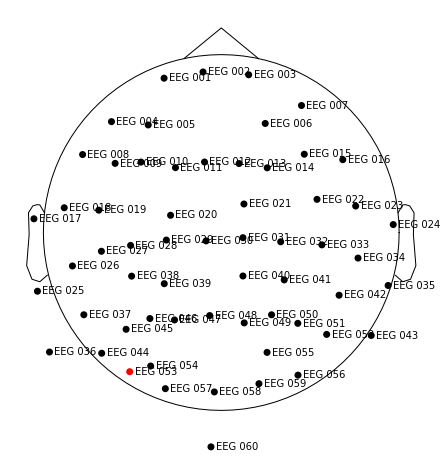

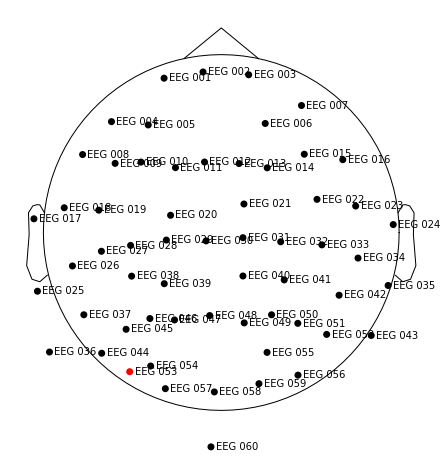

In [7]:
raw.plot_sensors(show_names=True)

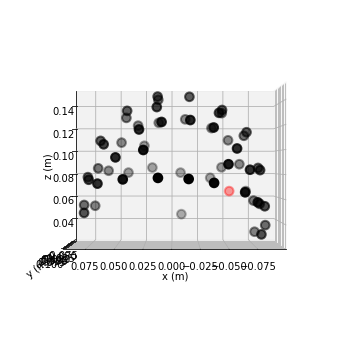

In [8]:
fig = raw.plot_sensors("3d")

Siempre que trabajamos con datos (cualquier sea su naturaleza) lo primero que tenemos que hacer es graficarlos. Aquí tiene sentido visualizar el EEG a lo largo del tiempo:

Using matplotlib as 2D backend.


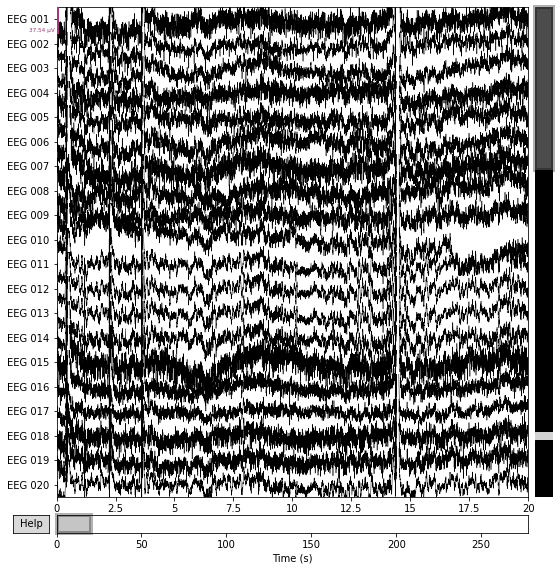

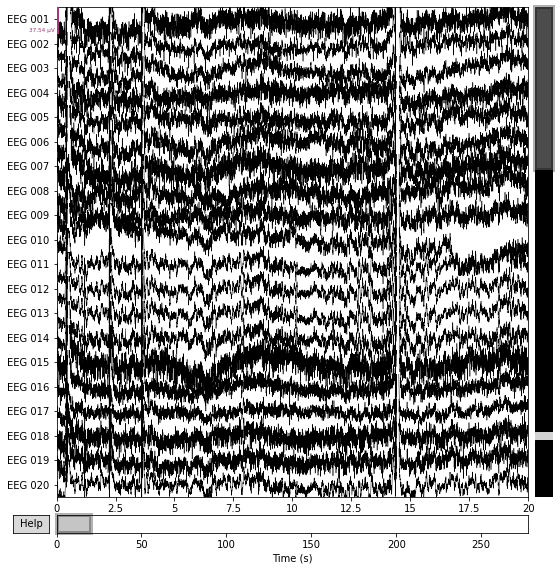

In [9]:
# podes jugar con el parámetro start para ir viendo diferentes porciones del EEG
raw.plot(scalings='auto', duration=20.0, start=0.0)

👀 Como podemos observar, en estos primero 20 canales de EEG graficados, no todos los canales de EEG capturan la misma "señal" en el mismo instante de tiempo. Algunos son más "ruidosos", otros tiene más interferencia de transiciones lentas (asociadas a la baja frecuencia), etc.

### Datos y eventos

En BCI, los datos suelen venir acompañados de información de eventos, los cuales son marcadores que indican el tiempo en el cuál sucedió tal o cuál evento. Esta información será la que nos ayudé evaluar la señal de EEG en segmentos de interés.

In [10]:
# importamos los eventos

events_file = root / "sample_audvis_raw-eve.fif"
events = mne.read_events(events_file)

#imprimos
print(events)

[[ 27977      0      2]
 [ 28345      0      3]
 [ 28771      0      1]
 [ 29219      0      4]
 [ 29652      0      2]
 [ 30025      0      3]
 [ 30450      0      1]
 [ 30839      0      4]
 [ 31240      0      2]
 [ 31665      0      3]
 [ 32101      0      1]
 [ 32519      0      4]
 [ 32935      0      2]
 [ 33325      0      3]
 [ 33712      0      1]
 [ 34089      0      5]
 [ 34532      0      2]
 [ 34649      0     32]
 [ 34956      0      3]
 [ 35428      0      1]
 [ 35850      0      4]
 [ 36211      0      2]
 [ 36576      0      3]
 [ 37007      0      1]
 [ 37460      0      4]
 [ 37910      0      2]
 [ 38326      0      3]
 [ 38711      0      1]
 [ 39130      0      4]
 [ 39563      0      2]
 [ 39926      0      3]
 [ 40405      0      1]
 [ 40880      0      4]
 [ 41260      0      2]
 [ 41646      0      3]
 [ 42126      0      1]
 [ 42598      0      5]
 [ 42938      0     32]
 [ 42960      0      2]
 [ 43346      0      3]
 [ 43781      0      1]
 [ 44170      0 

❓ ¿Mirando este arreglo de eventos, qué te parece que indica la primer columna y la última?

....

Es tarea de los experimentadores indicar a los usuarios de sus datos cuál es la relacción entre en número del marcador y la tarea mental o evento esperado. Para estos datos sabemos que:

| Evento      | Marcador |
| ----------- | ----------- |
| auditory/left      | 1     
| auditory/rigth   | 2    
| visual/left   | 3      
| visual/rigth   | 4    
| smiley   | 5    
| buttonpress   | 32      

Lo escribimos como un diccionario 👇     

In [11]:
event_dict = {
    "auditory/left": 1,
    "auditory/right": 2,
    "visual/left": 3,
    "visual/right": 4,
    "smiley": 5,
    "buttonpress": 32,
}

Algo muy útil que podemos hacer antes de comenzar a trabajar con nuestros datos es graficar los eventos, y así entender cuál es la distribución de eventos en mis datos

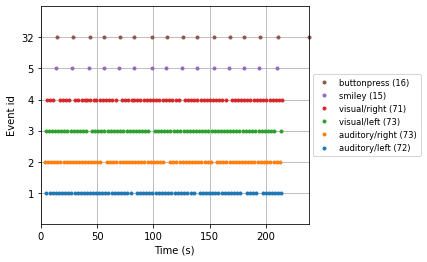

In [12]:
mne.viz.plot_events(
    events, sfreq=raw.info["sfreq"], first_samp=raw.first_samp, event_id=event_dict
);

También podemos graficar los datos crudos junto con la información de los eventos

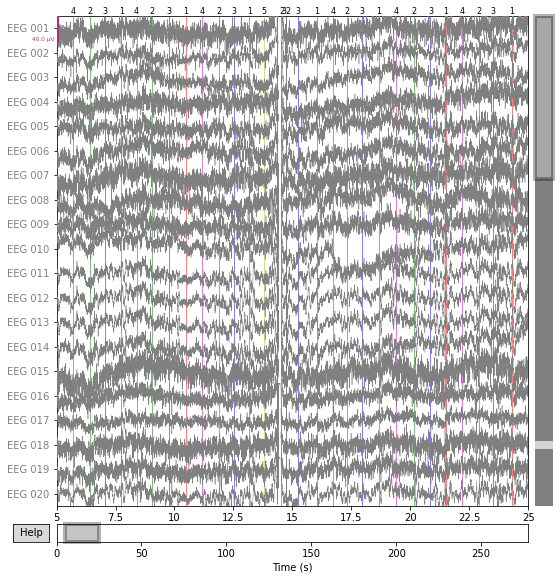

In [13]:
raw.plot(
    events=events,
    start=5,
    duration=20,
    color="gray",
    event_color={1: "r", 2: "g", 3: "b", 4: "m", 5: "y", 32: "k"},
);

❓ ¿De qué me servirá graficar los datos crudos junto con los marcadores de los eventos?

....

### Pasos de acondicionamiento básico

Cuando trabajamos con la señal de EEG hay una serie de pasos sencillos que me permiten acondicionar (de mínima) mi señal. Entre ellos encontramos:

1. Detección de canales "malos" (bad channels)
2. Filtrado de la señal
3. Submuestreo (downsampling)
4. Segmentación (epoching)
5. Detección de segmentos "malos" (bad trials)

¿Debo aplicar todos estos pasos? La respuesta es NO. Dependerá mucho de tus datos y aplicación.

De todos modos, veamos cada uno de estos pasos, por una cuestión didáctica 😉

#### Detección de canales "malos"

Esta tarea suele realizar mediante simple inspección visual, tanto durante el mismo experimento o luego del registro de los datos. A priori quisieramos marcar como canales "malos" aquellos que se comportan extrañamente durante todo o  la mayor parte del experimento.

❔ Será que sólo puedo marcarlos mediante observación visual? No se te ocurre alguna forma de hacerlo de manera automática?



...

Algo natural que uno podría pensar es en mirar cuán alejada está la varianza de ese canal con respecto a todos los canales. Tenemos que pensar que las señales de EEG son muestras aleatoreas identicamente distribuidas con una cierta distriubución. Si suponemos que los datos provienen de una distribución normal con media $\mu$ y desvío $SE$, cómo podré detectar aquellos canales "outliers"? Se te ocurre?

Vamos a implementarlo 👇

[0, 1, 2, 3, 6, 7]


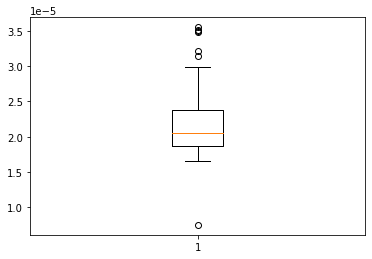

In [14]:
# guardo en un arreglo los datos crudos
data = raw.get_data()
nc, ns = np.shape(data) # cantidad de canales x cantidad de samples

# calculo el SE en cada canal
SE_all =[]
for nn in range(nc):
  SE_all.append(np.std(data[nn, :]))

#plotteo las distribución
plt.boxplot(SE_all)

#calculos los percentiles
q=np.percentile(SE_all, q=90)

# cheque si el SE de cada canal no se aleja demasiado del global
bad_channels = []
for nn in range(nc):
  SE =  np.std(data[nn, :])
  if abs(SE) > q:
    bad_channels.append(nn)
print(bad_channels)

In [15]:
np.shape(data)


(60, 166800)

❓ Perooooo, siempre sentido mirar a la varianza que ocurre a los largo de toooodo mi registro? no sé demasiado sensible o extricto este supuesto?

....

#### Filtrado

El filtrado de una señal permite eliminar o atenuar ciertas componentes frecuenciales en función de una cierta frecuencia de corte (cuttoff frequency).

Pero antes de adentrarnos en cómo filtrar nuestra señal de EEG, vamos a graficar en el espectro de frecuencias el EEG.

Sabemos que la señal de EEG superficial puede capturar señales no más lentas que 0.1 Hz y no más rápidas que 100 Hz.  

Effective window size : 3.410 (s)


c:\Users\felip\AppData\Local\Programs\Python\Python310\lib\site-packages\mne\viz\utils.py:161: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


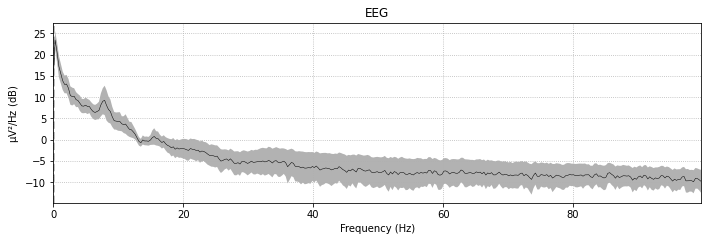

In [16]:
raw.compute_psd(fmax=100).plot(average=True, picks="data", exclude="bads");

La idea con un primer filtrado de datos es basicamente eliminar el ruido de continua (DC). Para eso, podemos filtrar nuestra señal con filtro pasa-alto. Se recomienda una frecuencia de corte no menor a 0.1 Hz.

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Filter length: 993 samples (1.653 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Effective window size : 3.410 (s)


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    1.0s finished
c:\Users\felip\AppData\Local\Programs\Python\Python310\lib\site-packages\mne\viz\utils.py:161: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


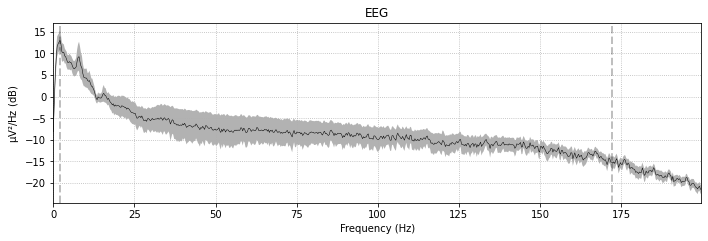

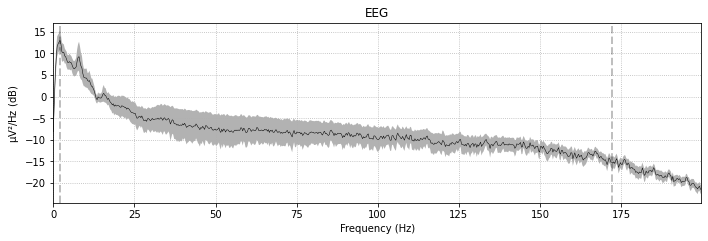

In [17]:
# ejecutá esta celda cambiando la frecuencia de corte
cutoff = 2
raw_highpass = raw.copy().filter(l_freq=cutoff, h_freq=None)
raw_highpass.compute_psd(fmax=200).plot(average=True, picks="data", exclude="bads")

❔ Pero, qué es lo que está ocurriendo?

Cuando uno filtra los datos, está aplicando un cierto umbral en el dominio de las frecuencias, en el cuál la información que no cumple con dicho umbral, es eliminada o atenuada.

En MNE-Python podemos facilmente visualizar el filtro aplicado, a modo de mejor comprender qué estamos haciendo:

Setting up high-pass filter at 2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Filter length: 993 samples (1.653 s)



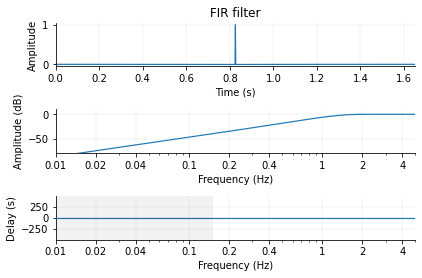

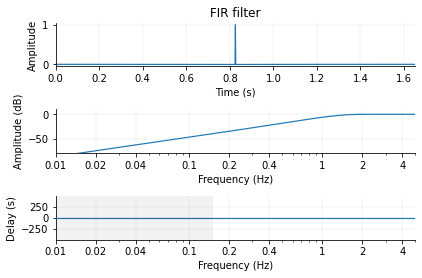

In [18]:
filter_params = mne.filter.create_filter(
    raw.get_data(), raw.info["sfreq"], l_freq=cutoff, h_freq=None)
mne.viz.plot_filter(filter_params, raw.info["sfreq"], flim=(0.01, 5))

#### Submuestro

En general, los sistemas de adquisición de EEG permiten muestrear temporalmente la señal a frecuencias muuuy altas. Pero, no siempre necesitamos tooodaaa esa infomración (puede ser redundante).

Sabiendo a donde se encuentra mi frecuencia máxima de interés, y siguiendo lo que dice el teorema de [Nysquit](https://en.wikipedia.org/wiki/Nyquist_frequency), podemos pensar que submuestrar mis datos a 200 Hz es un proceso "seguro".



Effective window size : 10.240 (s)


c:\Users\felip\AppData\Local\Programs\Python\Python310\lib\site-packages\mne\viz\utils.py:161: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


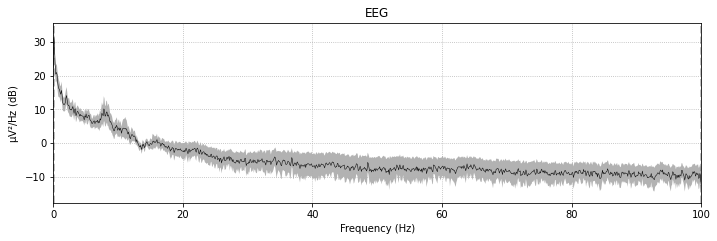

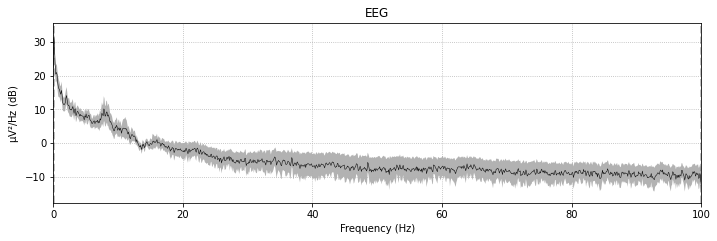

In [19]:
raw_highpass_downsampled = raw.copy().resample(sfreq=200)
raw_highpass_downsampled.compute_psd(fmax=100).plot(average=True, picks="data", exclude="bads")

In [20]:
# miramos el tamaño de mis datos
data_downsampled = raw_highpass_downsampled.get_data()
print(np.shape(data_downsampled))

(60, 55543)


❓ ¿Los datos se comprimieron? ¿Perdieron información frecuencial?

...

❕ Es importante mencionar que para evitar el fenomeno de [aliasing](https://en.wikipedia.org/wiki/Anti-aliasing_filter), necesitamos filtrar nuestros datos antes de submuestrearlos con un filtro pasa-bajos. En MNE-Python, la función resample ya realiza dicho paso por nosotro 🙂

❓ ¿Que consecuencias puede traer realizar el submuestreo en los datos crudos (raw)?

...

#### Segmentación

La segmentación es un proceso clave en el acondicionamiento de nuestros datos, pues al momento de hacer los registros el protocolo experimental puede contener ciertos eventos (tiempos) que no tiene nada de relevancia para un cierto estudio o análisis en particular.

Asimismo segmentar los datos en ventanas de tiempo precisas permitirán un mejor análisis posterior.

En el área, se denomina "trial" o "época" a un segmento de EEG de corta duración que está asociado a un evento de interés.

En MNE es MUY sencillo "epoquear" nuestros datos, pues la función [Epochs](https://mne.tools/stable/generated/mne.Epochs.html) es muy potente y fácil de utilizar.  Tenemos que saber el tiempo mínimo (tmin) y máximo (tmax) del cuál nos alejamos del marcador del evento a la izquiera y a la derecha, respectivamente:

Not setting metadata
320 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 320 events and 421 original time points ...
0 bad epochs dropped
You seem to have overlapping epochs. Some event lines may be duplicated in the plot.


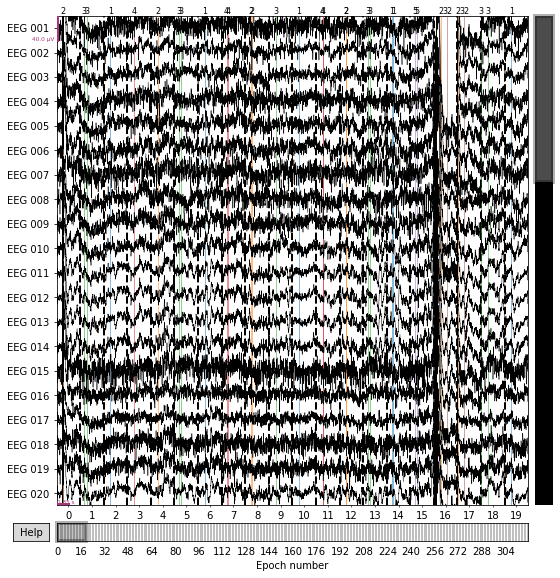

In [21]:
epochs = mne.Epochs(raw, events, tmin=-0.2, tmax=0.5, event_id=event_dict, preload=True)
epochs.plot(events=events);

❓ ¿Se podrá aplicar submuestro de mis datos después de haberlos segmentados? ¿Ventajas, desventajas?

....

#### Detección de segmentos "malos"

Puede suceder que en ciertos instantes de tiempos los datos tengan un comportamiento atípico/raro.

Para maximizar la calidad del análisis posterior de mis datos, puedo quitar de mi objeto `epochs` aquellos trials que están defectuosos.

Existen varias alternativas para automáticamente realizar esto. Se te ocurre alguna? 🤔

....

👀 veamos una ...

In [22]:
reject_criteria = dict(eeg=100e-6);
epochs.drop_bad(reject=reject_criteria);

    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006', 'EEG 007', 'EEG 009', 'EEG 010', 'EEG 011', 'EEG 012', 'EEG 013', 'EEG 014', 'EEG 015', 'EEG 016']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006', 'EEG 007', 'EEG 008', 'EEG 009', 'EEG 010', 'EEG 011', 'EEG 012', 'EEG 013', 'EEG 014', 'EEG 015', 'EEG 016', 'EEG 017', 'EEG 018', 'EEG 019', 'EEG 020', 'EEG 021', 'EEG 022', 'EEG 023', 'EEG 024', 'EEG 025', 'EEG 026', 'EEG 027', 'EEG 028', 'EEG 029', 'EEG 030', 'EEG 031', 'EEG 032', 'EEG 033', 'EEG 034', 'EEG 035', 'EEG 036', 'EEG 037', 'EEG 038', 'EEG 039', 'EEG 040', 'EEG 041', 'EEG 042', 'EEG 043', 'EEG 044', 'EEG 045', 'EEG 046', 'EEG 047', 'EEG 048', 'EEG 049', 'EEG 050', 'EEG 051', 'EEG 052', 'EEG 054', 'EEG 055', 'EEG 056', 'EEG 057', 'EEG 058', 'EEG 059', 'EEG 060']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 006', 'EEG 007', 'EEG 015'

❓ ¿Qué hace este criterio de rechazo?

...

Algo bastante útil es mirar qué canales contribuyeron mayoritariamente en las épocas malas

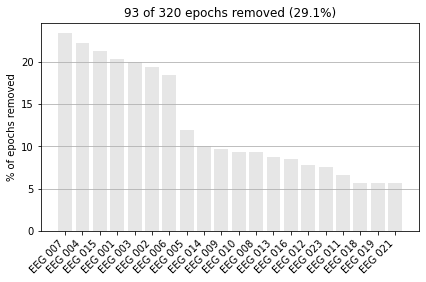

In [23]:
epochs.plot_drop_log();

❓ Hay una relación entre los canales que más contribuyen a las épocas malas y aquellos calculados en el primer paso?

¿Qué convendrá si hay uno o más canales contribuyendo a datos atípicos? Eliminar las épocas o eliminar los canales?

.....

❕ Diferentes criterios de eliminación de épocas ya están implementados en la función [Epochs](https://mne.tools/stable/generated/mne.Epochs.html). Es importante ver el valor que toman por defectos los correspondiente parámetros para que al momento de segmentar mis datos no se realice un proceso no deseado.

#### Mirando épocas

Una vez construido nuestro objeto `epochs`, podemos empezar a inspeccionar un poquito mi señal.

MNE provee funciones muy útiles. Pero antes, te preguntaste cómo acceder a sólo el subconjunto de épocas para un cierto evento?

👀 veaaamos

In [24]:
l_vis = epochs["visual/left"]
print(np.shape(l_vis))

(52, 60, 421)


❓ ¿Qué denota el tamaño del arreglo? ¿Cuántas épocas tengo dentro de la categoría "visual/left"?

...

Y finalmente vamos a poder graficar por ejemplo, el promedio de las épocas para todos los canales para el evento "visual/left"



NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
()


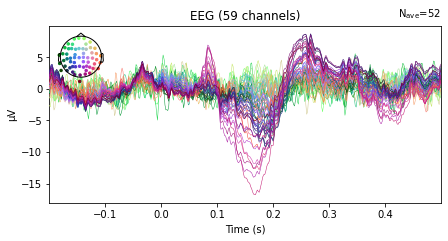

In [25]:
l_vis_mean = l_vis.average() # calculo el promedio
print(np.shape(l_vis_mean))
# grafico
l_vis_mean.plot(spatial_colors=True);

❓ ¿Se observa el mismo comportamiento en todos los canales? ¿Se observan potenciales marcados?

💡 Para responder esta pregunta recordá de qué tipo de paradigma provienen estos datos

#### El efecto del submuestreo

Para que termines de entender lo importante y relevante que puede ser filtrado y submuestrear nuestros datos te vamos a pedir que realices el siguiente "experimento":

1. Filtrá los datos crudos a 1/3 de la frecuencia de muestreo final deseada y remuestreá los datos crudos a la frecuencia de muestreo deseada. Se desea tener un frecuencia de muestreo de 200 Hz. Segmentá los datos y graficá el espectro para la categoría "visual/left" antes y después de aplicado el proceso de remuestreo.
2. Filtrá los datos crudos a 1/3 de la frecuencia de muestro final deseada, segmentá los datos utilizando el parámetro `decimate` para submuestrear los datos. Como antes, la nueva frecuencia de muestreo deseada es 200 Hz. Graficá el espectro para la categoría "visual/left" antes y después de aplicado el proceso de remuestreo.


In [26]:
#escribó tú código acá

❓ ¿Qué observas? ¿Qué proceso es el más seguro?

....

## Parte III: ERPs

Los potenciales evocados relacionados a eventos (ERPs, por sus siglas en inglés) suelen encontrarse entre los 1 a 12 Hz. Según sea el tipo de estímulo utilizado podrán tener morfologías diferentes, con latencias diferentes. En general solemos observarlos a partir de la promediación coherente de segmentos de EEG.

##### Los datos

Vamos a utilizar los mismos datos que antes

In [27]:
root = mne.datasets.sample.data_path() / "MEG" / "sample"
raw_file = root / "sample_audvis_raw.fif"
raw_erps = mne.io.read_raw_fif(raw_file, preload=True)

events_file = root / "sample_audvis_raw-eve.fif"
events_erps = mne.read_events(events_file)

event_erps_dict = {
    "auditory/left": 1,
    "auditory/right": 2,
    "visual/left": 3,
    "visual/right": 4,
    "smiley": 5,
    "buttonpress": 32,
}

# sampling freq
sfreq = raw_erps.info["sfreq"]


Opening raw data file C:\Users\felip\mne_data\MNE-sample-data\MEG\sample\sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...


#### Manos a la obra 🤝

1. Creá el objeto `epochs_erp`, el cuál tiene los datos filtrados entre 0.1 a 40 Hz, con segmentos de EEG de 1 segundo de duración extraídos justo luego de la presentación del estímulo. Resamplea los datos tomando cada 4 muestras. No realices eliminación de canales ni de épocas. No realices corrección de baseline. Al finalizar chequeá el tamaño de los datos extraídos e indicá si tiene sentido.

💡 TIPs

1. Estudía bien los parámetros de la función [Epochs](https://mne.tools/stable/generated/mne.Epochs.html#mne.Epochs) de MNE
2. Recordá que los datos tienen varias modalidades. Seleccioná solo EEG.

In [28]:
# escribí tú código acá

2. Realizá la promediación coherente para las épocas correspondientes a estímulo "visual/left". Realizá las graficas para un grupo de canales, seleccionado en función de donde esperes que se observe más notoriamente el EPR. Comenzá promediando 2 segmentos de EEG hasta llegar a 60 en pasos de 2. Responde: ¿desde qué número de trials promediados fuiste capaz de observar el ERP?

In [29]:
# escribí tú código acá

3. Repetí el proceso pero ahora filtrando los datos entre 1 y 12 Hz. ¿Es más fácil visualizar la onda P300?

In [30]:
#Escribí tú código acá

## Parte IV: SSVEP

Los potenciales de SSVEP se caracterizan por responder a la frecuencia de estimulación. Para
discriminar entre posibles comandos utilizando SSVEP, suele utilizarse la [transformada de Fourier](https://es.wikipedia.org/wiki/Transformada_de_Fourier)
y analizar la potencia del espectro en una banda acotada de interés, de manera tal que la frecuencia fundamental indique el tipo de comando seleccionado por el usuario de la BCI.

#### Los datos

Estos datos también son parte de las bases de datos accesibles mediante MNE. Es una base de datos en el cuál dos participantes observaban un tablero de ajedrés que invertía los colores a frecuencias constantes de 12 o 15 Hz. Se utilizaron 32 canales de EEG. Los registros contemplan 10 trials de 20 s de duración cada uno

In [31]:
data_path = mne.datasets.ssvep.data_path()
bids_fname = (
    data_path / "sub-02" / "ses-01" / "eeg" / "sub-02_ses-01_task-ssvep_eeg.vhdr"
)

raw_ssvep = mne.io.read_raw_brainvision(bids_fname, preload=True, verbose=False)
raw_ssvep.info["line_freq"] = 50.0

# Set montage
montage = mne.channels.make_standard_montage("easycap-M1")
raw_ssvep.set_montage(montage, verbose=False)

# event
event_ssvep_id = {"12hz": 255, "15hz": 155}
events_ssvep, _ = mne.events_from_annotations(raw_ssvep, verbose=False)

#channel names
ch_n = raw_ssvep.ch_names

Using default location ~/mne_data for ssvep...


 44%|################8                     | 17.5M/39.5M [01:07<01:21, 270kB/s]

KeyboardInterrupt: 

 44%|################8                     | 17.5M/39.5M [01:20<01:21, 270kB/s]

In [ ]:
# vemos los canales
raw_ssvep.plot_sensors(show_names=True);

#### Manos a la obra 🤝

1. Creá el objeto `epochs_ssvep`, el cuál tiene los datos filtrados en 0.1 Hz, con segmentos de EEG de extraídos 20 segundos luego de la presentación del estímulo con 1 segundo de espera. No realices eliminación de canales ni de épocas. No realices corrección de baseline. Al finalizar chequea el tamaño de los datos extraídos e indicá si tiene sentido.

In [ ]:
# escribí tú código acá

❓ ¿Será relevante mirar las señales en todos los canales? ¿No habrá una región de interés (ROI)? ¿Por qué esperamos 1 segundo para segmentar los datos?

...

## Parte V: SRMs

Los ritmos sensorimotores (SRMs, por sus siglas en inglés) pueden observanse en la señal de EEG en tareas de imaginería motora. Estos potenciales suelen observarse en el dominio temporal entre los 8 a 30 Hz (onda $\mu$ y $\beta$). Asimismo, pueden observarse en el dominio temporal como un cambio en la amplitud con respecto a una estado de base

#### Los datos

Vamos a utilizar datos de imaginería motora. Esta base de datos fue originalmente publicada en [2] y consiste en varios experimentos de BCI realizados a la misma persona. En esta práctica vamos a utilizar las rondas correspondientes a imaginería motora de mano derecha vs. izq. del subjeto 1.

In [ ]:
from mne.datasets import eegbci

subject = 1  # sujeto
runs = [4, 8, 12]  # motor imagery: left vs right hand runs

raw_fnames = eegbci.load_data(subject, runs)
raw_srms = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])

# montage
eegbci.standardize(raw_srms)  # set channel names
montage = make_standard_montage("standard_1005")
raw_srms.set_montage(montage)

# eventos por anotaciones
dict_srm_event = dict(T1=1, T2=2) #right and left
events_srms, _ = events_from_annotations(raw_srms, event_id=dict_srm_event)


In [ ]:
# vemos los canales
raw_srms.plot_sensors(show_names=True);

#### Manos a la obra 🤝

1.  Creá el objeto `epochs_rms` con segmentos de EEG de 5 segundos de duración extraídos 1 segundos antes de la presentación del estímulo. Seleccioná solo los canales C3, C4, y Cz. Filtrá los datos entre 1 a 40 Hz. Al finalizar chequea el tamaño de los datos extraídos e indicá si éste tiene sentido.

In [ ]:
# escribí tú código acá

2. Grafica los espectros promedios de las épocas de imaginería motora (MI, por sus siglas en inglés) derechas e izquierdas.

💡 TIP: chusmeá como usar el métdo `compute_psd` de los objetos [Epochs](https://mne.tools/stable/generated/mne.Epochs.html) de MNE.

In [ ]:
# escribí tú código acá

3. Los patrones de sincronización y desincronización relacionado a eventos (ERD/ERS) pueden
detectarse mediante los siguientes pasos:



*   (1) Filtrado pasabanda;
*   (2) Rectificación
*   (3) Promediación sobre $N$ señales rectificadas.


  Asimismo denotando con $A$ y $R$ a la potencia dentro de una banda de frecuencia de interés
  luego del evento y dentro de un periodo de referencia (baseline), respectivamente, los valores de crecimiento y decrecimiento porcentuales pueden calcularse mediante $ERD\%$ = $(A-R)=R/100$.

  Mediante esta visualización, la escala muestra cambios de potencia entre 0% y 100%. Ambos
  procedimientos se detallan en la siguiente figura.

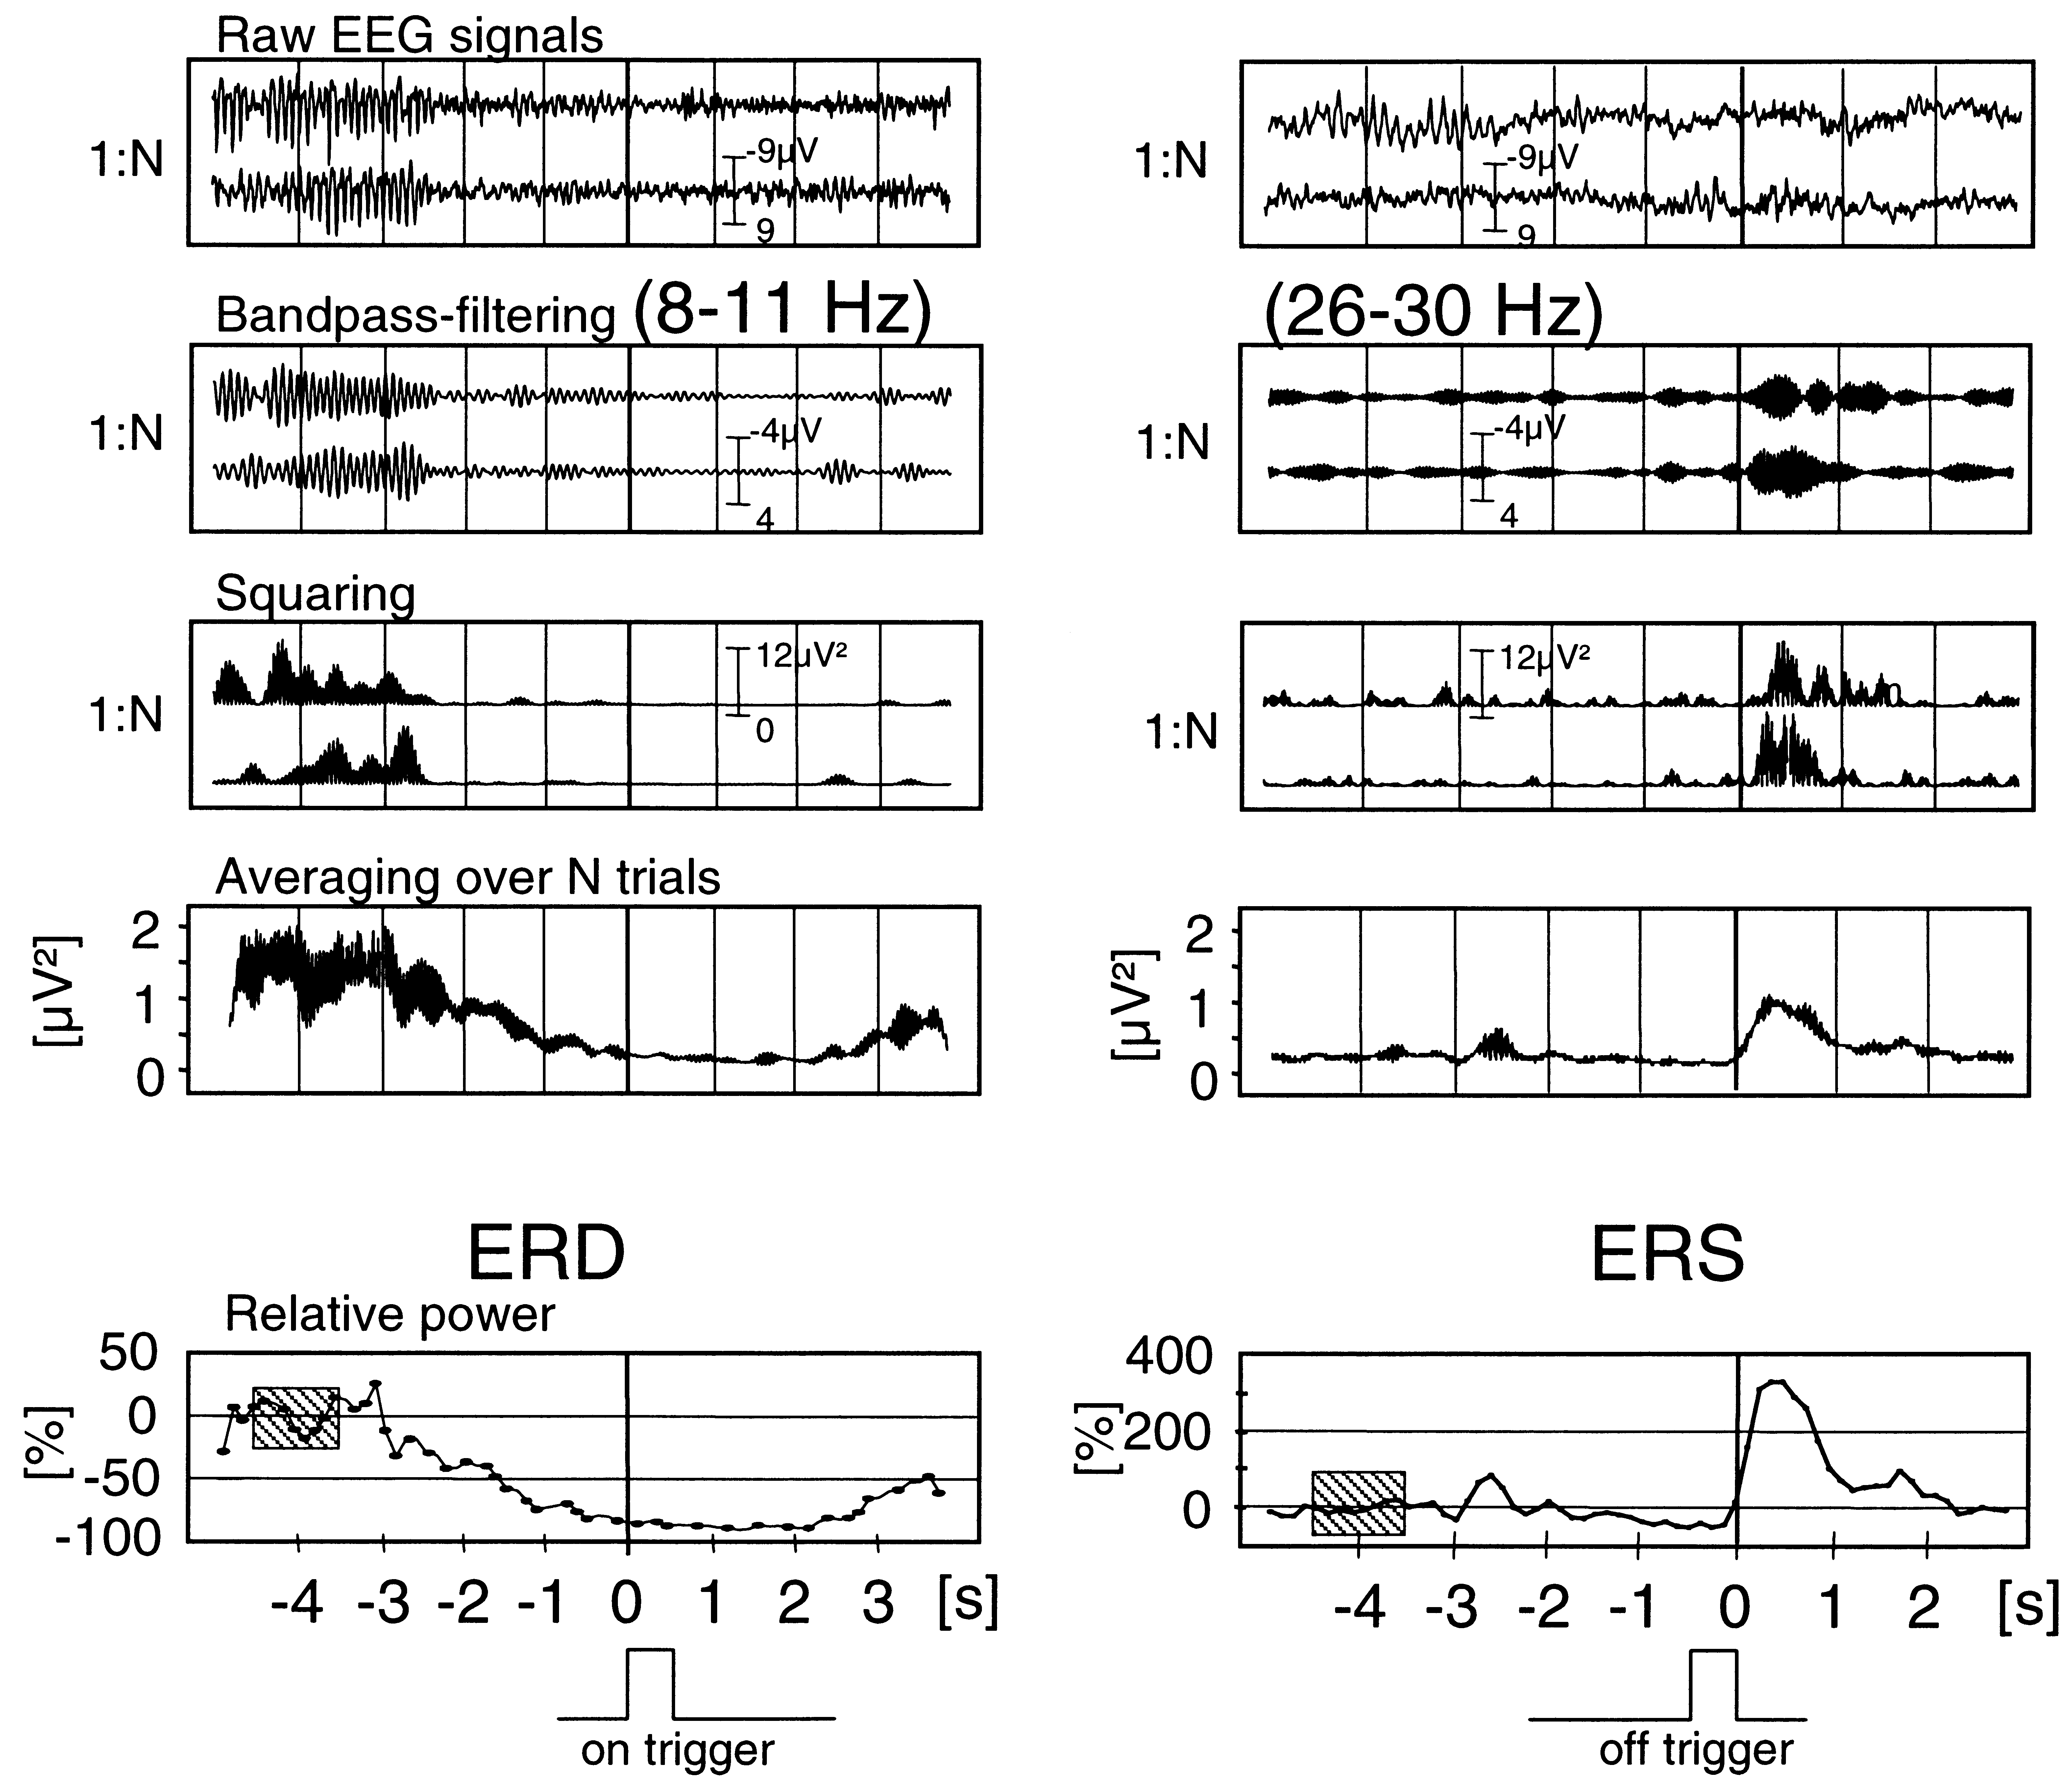

**Figura extraída de [3]

  Se te pide que utilices las señales de MI extraídas anteriormente en los canales 'C3' y 'C4'.
  Grafique los patrones ERD/ERS replicando la Figura 2 hasta el promedio sobre N trials.
  Para ello sólo utilice los patrones que contienen MI. Como en la figura, filtrá la señal entre 8 a 12 Hz. Indicá el tiempo en el eje x relativo al evento (denotado como *trigger* en la figura).

In [ ]:
# escribí tú código acá

#### Bonus track

Veamos como se observan los ERD/s como mapas topográficos en el espacio de los sensores

Para mejor visualizar estos ERD/S en el topomap, vamos a crearnos épocas de 2 segundos de duración 0.5 segundos luego de aplicado el estímulo, sin selección de un grupo de canales.

Luego vamos a separar las épocas izq. de las derechas

In [ ]:
# hacemos corrección del baseline
epochs_srm2= mne.Epochs(
    raw_srms,
    events_srms,
    dict_srm_event,
    -1,
    4,
    proj=False,
    picks="eeg",
    baseline=(-1, 0),
    preload=True,
)
# recortamos entre el segmento de interés
epochs_srm2.crop(0.5, 2.5)

right_spectrum2 = epochs_srm2["T1"].compute_psd()
left_spectrum2 = epochs_srm2["T2"].compute_psd()



In [ ]:
fig, axs = plt.subplots(1, 5, figsize=[12, 1.2])
right_spectrum2.plot_topomap(ch_type="eeg", agg_fun=np.median, cmap='RdBu_r',
                            normalize=True, axes=axs);
fig.suptitle('Right hand MI', y=1.35);
fig, axs = plt.subplots(1, 5, figsize=[12, 1.2])
left_spectrum2.plot_topomap(ch_type="eeg", agg_fun=np.median, cmap='RdBu_r',
                           normalize=True, axes=axs);
fig.suptitle('Left hand MI', y=1.35);

❓ ¿Qué observas? ¿Hay alguna banda de frecuencia con ERD relacionados a la imaginería motora?

...

# Quiero saber más 🤓

⚡ Para saber más de filtrado, podes mirarte [éste](https://mne.tools/stable/auto_tutorials/preprocessing/30_filtering_resampling.html) tutorial de MNE-Python

👀 Para chusmear más de como visualizar ERD/ERS miráte [este](https://mne.tools/dev/auto_examples/time_frequency/time_frequency_erds.html) tutorial de MNE

🔦 Para aprender sobre más de cómo trabajar con señales de SSVEP mirate [este](https://mne.tools/stable/auto_tutorials/time-freq/50_ssvep.html#tut-ssvep) ejemplo

# Referencias

[1] Zafer İşcan and Vadim V Nikulin. Steady state visual evoked potential (ssvep) based brain-computer interface (BCI) performance under different perturbations. PloS one, 13(1):e0191673, 2018.

[2] Gerwin Schalk, Dennis J. McFarland, Thilo Hinterberger, Niels Birbaumer, and Jonathan R. Wolpaw. BCI2000: a general-purpose brain-computer interface (BCI) system. IEEE Transactions on Biomedical Engineering, 51(6):1034–1043, 2004. doi:10.1109/TBME.2004.827072.

[3] Gert Pfurtscheller and FH Lopes Da Silva. Event-related eeg/meg synchronization and desynchronization: basic principles. Clinical neurophysiology, 110(11):1842-1857, 1999.